# Method 2

**What is Isolation Forest**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## Imports

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

## Load datset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Numerical/creditcard.csv")
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


<Axes: xlabel='Class'>

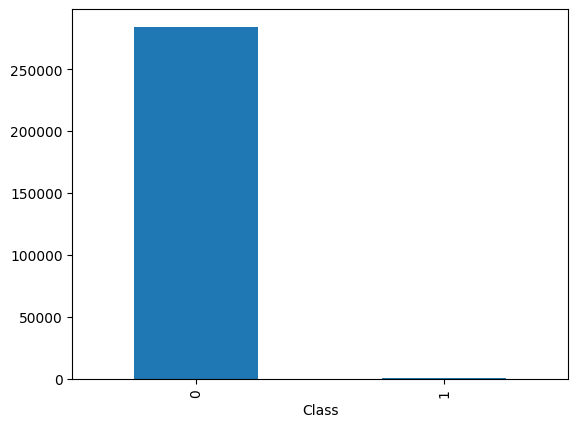

In [3]:
print(df.Class.value_counts())
df.Class.value_counts().plot(kind='bar')

## Data formating

In [4]:
seed = 1337

def get_data(df, clean_train=True):
  """
      clean_train=True returns a train sample that only contains clean samples.
      Otherwise, it will return a subset of each class in train and test (10% outlier)
  """
  clean = df[df.Class == 0].copy().reset_index(drop=True)
  fraud = df[df.Class == 1].copy().reset_index(drop=True)
  print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

  if clean_train:
      train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
      print(f'Train Samples: {len(train)}')

      test = pd.concat([test_clean, fraud]).reset_index(drop=True)

      print(f'Test Samples: {len(test)}')

      # shuffle the test data
      test.sample(frac=1, random_state=seed).reset_index(drop=True)

      train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
      test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
  else:
      clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
      fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)

      train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
      test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)

      # shuffle
      train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)

      print(f'Train Samples: {len(train_samples)}')
      test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)

      print(f'Test Samples: {len(test_samples)}')
      train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
      test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]

  return train_X, train_y, test_X, test_y

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


In [5]:
train_X, train_y, test_X, test_y = get_data(df)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


## Train on only Normal dataset

In [6]:
model = IsolationForest(random_state=seed)
model.fit(train_X, train_y)

IsolationForest(random_state=1337)

In [8]:
def predict(X):
    test_yhat = model.predict(X)
    # values are -1 and 1 (-1 for outliers and 1 for inliers), thus we will map it to 0 (inlier) and 1 (outlier) as this is our target variable
    test_yhat = np.array([1 if y == -1 else 0 for y in test_yhat])
    return test_yhat

In [9]:
test_yhat = predict(test_X)

In [12]:
def get_confusion_matrix(test_y, test_yhat):
  cm = confusion_matrix(test_y, test_yhat)

  fig, ax = plt.subplots(1, 1,figsize=(10,10))

  tick_labels = ['Normal','Fraudulent']

  # calculate output
  total = np.sum(cm)

  # Actually True
  tp = cm[0][0]
  fn = cm[0][1]

  # Actually false
  fp = cm[1][0]
  tn = cm[1][1]

  tp_o = np.round((tp / total)*100,3)
  fn_o = np.round((fn / total)*100,3)
  fp_o = np.round((fp / total)*100,3)
  tn_o = np.round((tn / total)*100,3)

  tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
  fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
  fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
  tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)

  labels = np.array([
      [f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%',
       f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'],
      [f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%',
       f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%']
      ])

  sns.heatmap(cm, ax=ax, annot=labels, fmt='', cmap=plt.cm.RdYlBu)

  ax.set_title('Confusion Matrix', fontsize=14)

  ax.set_xticklabels(tick_labels, fontsize=14, rotation=0)
  ax.set_xlabel('Predicted', fontsize=20)
  ax.set_yticklabels(tick_labels, fontsize=14, rotation=0)
  ax.set_ylabel('Actual', fontsize=20)

  plt.show()

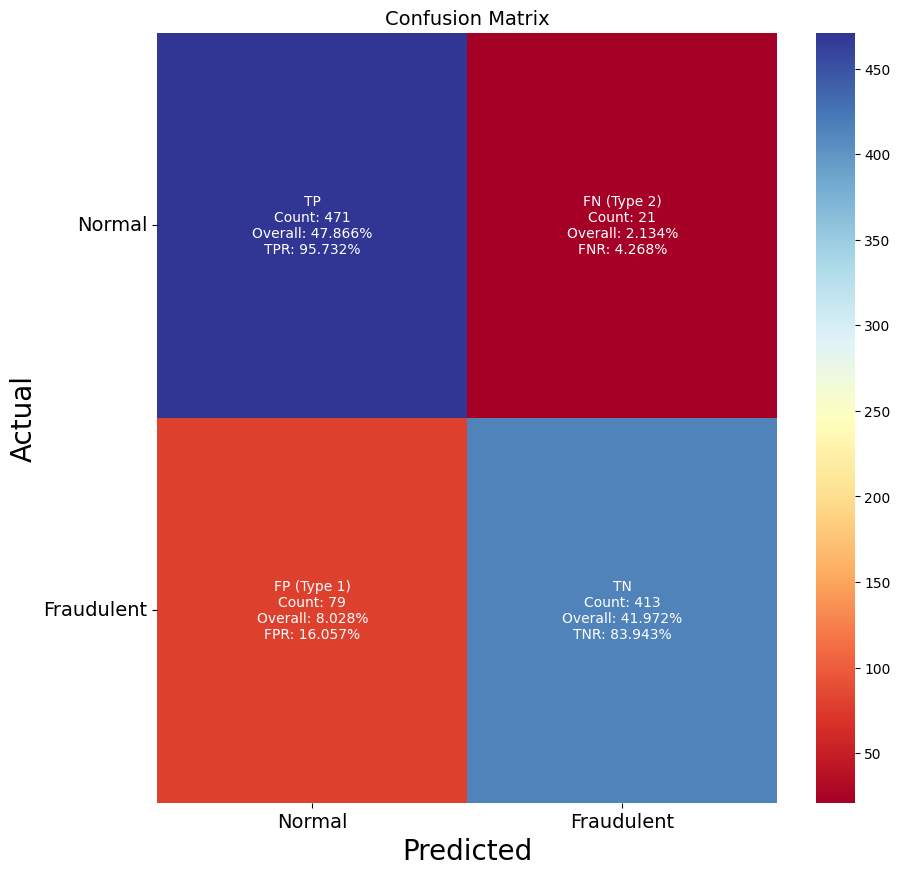

In [13]:
get_confusion_matrix(test_y, test_yhat)

In [14]:
def get_classification_report(test_y, test_yhat):
    labels = ['Normal','Fraudulent']
    print(classification_report(test_y, test_yhat, target_names=labels))

In [15]:
get_classification_report(test_y, test_yhat)

              precision    recall  f1-score   support

      Normal       0.86      0.96      0.90       492
  Fraudulent       0.95      0.84      0.89       492

    accuracy                           0.90       984
   macro avg       0.90      0.90      0.90       984
weighted avg       0.90      0.90      0.90       984



## Training on Both Normal and fraud dataset

In [16]:
train_X, train_y, test_X, test_y = get_data(df, clean_train=False)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283824
Test Samples: 983


In [ ]:
model = IsolationForest(random_state=seed)
model.fit(train_X, train_y)

In [ ]:
test_yhat = predict(test_X)

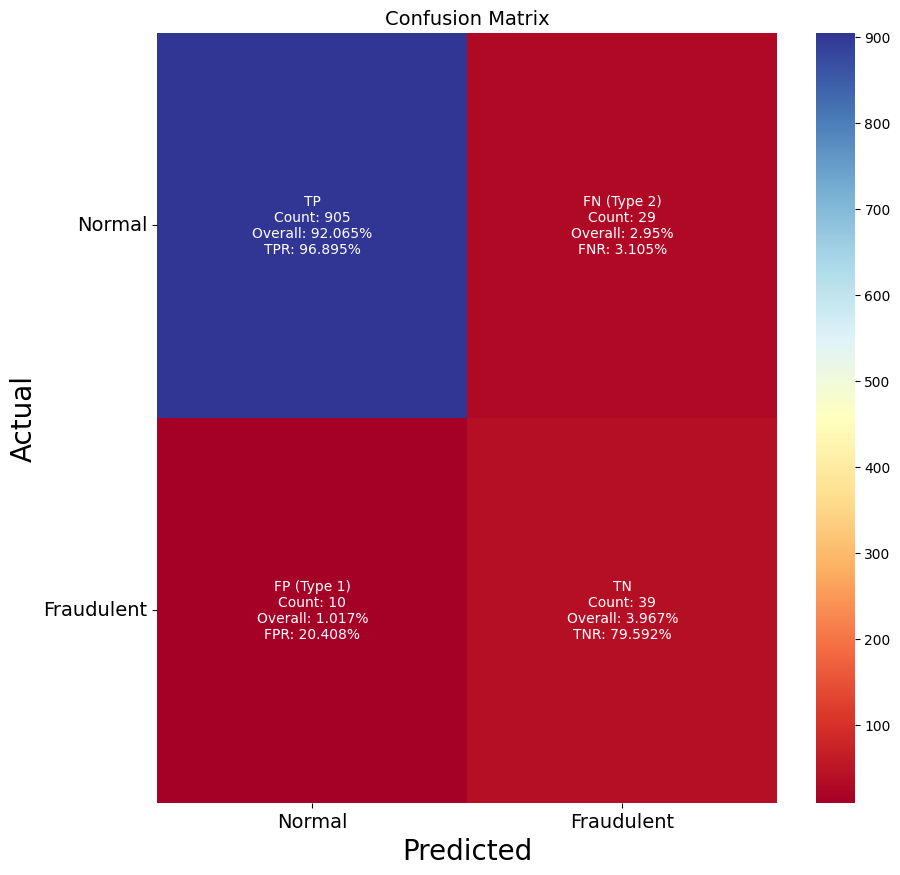

In [17]:
get_confusion_matrix(test_y, test_yhat)

In [18]:
get_classification_report(test_y, test_yhat)

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       934
  Fraudulent       0.57      0.80      0.67        49

    accuracy                           0.96       983
   macro avg       0.78      0.88      0.82       983
weighted avg       0.97      0.96      0.96       983



Here, when we train on both normal and fruad dataset the prediction becomes worse